# Point Clouds: Subsampling and Neighborhood




Pour tout $x \in \mathbb{R}^d$, nous notons $d(x, S) = \inf_{s \in S} d(x, s)$ (où le dernier $d(\cdot, \cdot)$ représente la distance euclidienne entre les points) et nous appelons le $s$ qui atteint le minimum le centre de $x$. \\
$p_i$ est alors défini comme le point $p \in P \setminus S_{i-1}$ qui maximise $d(p, S_{i-1})$

#### Importation des bibliothèques nécessaires et définition de fonctions utiles

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
import time

import functools

from sklearn.datasets import make_blobs

In [2]:
def generate_points(num_points):

    # Generation de points aléatoires
    x = np.random.rand(num_points)
    y = np.random.rand(num_points)

    plt.scatter(x, y)
    plt.show()

    P=[(x[i],y[i]) for i in range(num_points)]
    return P

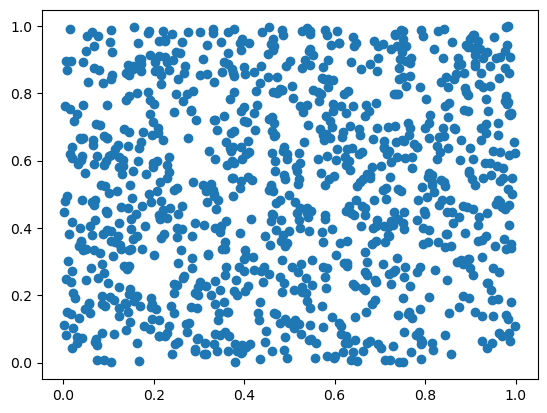

In [3]:
P=generate_points(1000)

* La distance euclidienne entre deux points :

* Le cache est utilisé pour stocker les distances entre les points pour éviter de recalculer les distances entre les mêmes points plusieurs fois.

In [4]:
@functools.cache #pour ne pas recalculer la distance entre les mêmes points
def normy(p,q):
    """Calcule la distance euclidienne entre deux points."""
    return sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)



Distance entre un point et un nuage de points :

In [5]:
def calculate_distance(point, points_set):
    d = float('inf')
    for i in points_set:
      q=i
      if normy(point,q) < d:
        d, center = normy(point,q), q
    return d #, center


In [6]:
# # Pour vider le cache
# normy.cache_clear()

### Task 1:
Un algorithme naïf qui prend en entrée $P$, $p_1 \in P$ et $k$ et calcule la séquence des centres $p_1, \ldots, p_k$, avec une complexité $O(n^3)$.

In [7]:
def naive_algorithm(P, i, k, runtime=False):
    """
    Algorithme naïf pour sélectionner k centres à partir d'un ensemble de points.

    Paramètres:
    P (list): Liste de points.
    i (int): Indice du centre initial.
    k (int): Nombre de centres à sélectionner.
    runtime (bool, facultatif): Indicateur pour afficher le temps d'exécution de l'algorithme.

    Retourne:
    list: Liste d'indices représentant les centres sélectionnés.
    """
    start_time = time.time()
    center_set = {i}
    centers = [i] # indices des points
    for _ in range(k-1):
        max_distance = 0
        farthest_point = None
        for i, p in enumerate(P):
            if p not in center_set: # O(1) en moyenne
                distance = calculate_distance(p, [P[j] for j in center_set])


                if distance > max_distance:
                    max_distance = distance
                    farthest_point = i


        centers.append(farthest_point)
        center_set.add(farthest_point)

    end_time = time.time()
    run = end_time - start_time
    if runtime:
        print(f"Runtime: {run} seconds")

    return centers

**Complexité :**  $O(nk^2)$

À chaque itération, on parcourt tous les points pour trouver le plus éloigné du $S$. Cela prend $O(i(n-i))$ où $i$ est le nombre de centres.

D'où:

$$
\begin{align*}
\sum_{i=1}^{k-1} i (n-i) &= \sum_{i=1}^{k-1} (in - i^2) \\
&= \sum_{i=1}^{k-1} in - \sum_{i=1}^{k-1} i^2 \\
&= n \sum_{i=1}^{k-1} i - \sum_{i=1}^{k-1} i^2 \\
&= n \left(\frac{(k-1)k}{2}\right) - \frac{(k-1)k(2k-1)}{6} \\
&= \frac{n(k-1)k}{2} - \frac{(k-1)k(2k-1)}{6} \\
&= \frac{(k-1)k}{6} (3n - (2k-1)) \\
&= O(nk^2)
\end{align*}
$$


### Task 2:

Il est possible de calculer cette séquence de manière plus efficace. L'idée clé est de se souvenir, pour chaque point dans $P \setminus S$, de sa distance à $S$. Il est alors possible de trouver en temps linéaire le maximum de cette liste. Une fois le nouveau point $p_i$ déterminé, la mise à jour de la liste des distances à $S \cup {p_i}$ prend également un temps linéaire.


Un algorithme qui calcule la séquence $p_1, \ldots, p_k$, avec une complexité $O(nk)$:

In [8]:
def efficient_algorithm(P, i, k, runtime=False):

    """
    Algorithme plus efficace O(nk) pour sélectionner k centres à partir d'un ensemble de points.

    Paramètres:
    P (list): Liste de points.
    i (int): Indice du centre initial.
    k (int): Nombre de centres à sélectionner.
    runtime (bool, facultatif): Indicateur pour afficher le temps d'exécution de l'algorithme.

    Retourne:
    list: Liste d'indices représentant les centres sélectionnés.
    """
    start_time = time.time()
    centers = [i]
    distances = {j: normy(P[j], P[i]) for j in range(len(P)) if j != i}
    for _ in range(k - 1):
        farthest = max(distances, key=distances.get)
        centers.append(farthest)
        distances.pop(farthest)
        for key, value in distances.items():
            cur_distance = normy(P[farthest], P[key])
            if cur_distance < value:
                distances[key] = cur_distance
    end_time = time.time()
    run = end_time - start_time
    if runtime:
        print(f"Runtime: {run} seconds")
    return centers


**Complexité :**  $O(nk)$

À chaque itération, on parcourt tous les points pour trouver le plus éloigné du $S$ en utilisant les distances de chacun à $S$.   

Parcourir `distances` prend $O(n-i)$ où i  est l'itération courante, donc c'est au plus linéaire.   

D'où la complexité $O(nk)$.

### Task 3 :
Pour trouver $p_i$, au lieu de parcourir tous les points de $P$ (ou $P \setminus S$) pour trouver celui avec la distance maximale à $S$, nous pourrions maintenir pour chaque centre $s \in S$ la liste des points de $P \setminus S$ qui ont $s$ comme leur centre (nous appelons cette liste la **région** de $s$), en s'assurant que celui le plus éloigné de $s$ peut être rapidement accédé (nous appelons rayon de $s$ la distance maximale de $s$ à un point de sa région). Ainsi, nous avons seulement besoin d'itérer sur $S$ pour trouver le centre avec le rayon maximal.

***Mise à jour :*** $d$ est la distance euclidienne et en particulier une métrique, donc elle satisfait l'inégalité triangulaire $d(a, c) \leq d(a, b) + d(b, c)$. Après avoir sélectionné $p_i$ comme nouveau centre, puisque la distance de $p_i$ à $s_j$ est très grande par rapport au rayon de $s_j$, tous les points qui avaient $s_j$ comme leur centre garderont le même centre, nous n'avons pas besoin de les vérifier un par un. Nous pouvons tester pour chaque ancien centre si le nouveau centre est assez proche pour qu'il puisse voler des points pour sa région, et vérifier uniquement les points de ces régions en détail.

> Une condition nécessaire pour cela est que $\mathbf{d(p,s) \leq 2 \cdot Rayon(s)}$, où $p$ est le nouveau centre, $s$ est un centre.

Un algorithme qui calcule la séquence $p_1, \ldots, p_k$ de manière efficace tant que $k$ n'est pas trop grand :


In [9]:
def efficient_algorithm_smallk(P, i, k, runtime=False):
    """
    Algorithme plus efficace O(nk) pour sélectionner k centres à partir d'un ensemble de points.
    Cette version est optimisée pour les petits k.

    Paramètres:
    P (list): Liste de points.
    i (int): Indice du centre initial.
    k (int): Nombre de centres à sélectionner.
    runtime (bool, facultatif): Indicateur pour afficher le temps d'exécution de l'algorithme.

    Variables:
    centers (list): Liste d'indices représentant les centres sélectionnés.
    regions (dict): Dictionnaire contenant les régions de chaque centre.
    radii_elt (dict): Dictionnaire contenant ,pour chaque centre, l'indice du point le plus éloigné de sa région.
    radii (dict): Dictionnaire contenant, pour chaque centre, le rayon de sa région.

    Retourne:
    list: Liste d'indices représentant les centres sélectionnés.
    """

    start_time = time.time()
    centers = [i]

    regions = {i: {j for j in range(len(P)) if j != i}} # use a heap instead of set to access the max quicker
    radii_elt = {i : max({j for j in range(len(P)) if j != i}, key=lambda x: normy(P[x], P[i]))}
    radii = {i: normy(P[radii_elt[i]], P[i])}

    for _ in range(k - 1):
        # Trouver le nouveau centre

        center = max(radii, key=radii.get) # Linéaire , enter est l'ancien centre
        farthest_point = radii_elt[center] # le nouveau centre
        centers.append(farthest_point) # O(1)



        stolen_points = set()
        far_radius = -1
        far_radii_elt = farthest_point
        for cen, region in regions.items(): # O(n) worst case

            if not region: # Si la région est vide il n'y a pas de point à voler
                continue


            center_change_Flag=False # Afin d'optimiser la mise à jour de radii et radii_elt

            if normy(P[farthest_point], P[cen]) < 2 * radii[cen]: # Condition nécessaire pour voler des points

                center_change_Flag=True

                center_new_radius = -1
                center_new_radii_elt = cen

                region_copy = region.copy() # parce qu'on va modifier region
                for j in region_copy:
                    cur_distance = normy(P[j], P[cen])
                    far_j_distance = normy(P[j], P[farthest_point])
                    if cur_distance > far_j_distance:

                        region.remove(j)
                        stolen_points.add(j)



                        # Mise à jour du rayon du farthest_point : far_radius = max(far_radius, far_j_distance)
                        if far_j_distance > far_radius:
                            far_radius = far_j_distance
                            far_radii_elt = j


                    else:



                        # Mis à jour du rayon du centre center_new_radius = max(center_new_radius, cur_distance)
                        if cur_distance > center_new_radius:
                            center_new_radius = cur_distance
                            center_new_radii_elt = j




            # Mise à jour de radii et radii_elt
            if center_change_Flag:
                radii[cen] = center_new_radius
                radii_elt[cen] = center_new_radii_elt
            else: # S'il ne vole aucun point
                radii_elt[cen] =  max(region, key=lambda x: normy(P[x], P[cen])) # if he didn't steal any point, he will never
                radii[cen] = normy(P[radii_elt[cen]], P[cen])

        # Mise à jour de la région, rayon   du farthest_point
        regions[farthest_point] = stolen_points
        radii[farthest_point] = far_radius
        radii_elt[farthest_point] = far_radii_elt

    end_time = time.time()
    run = end_time - start_time
    if runtime:
        print(f"Runtime: {run} seconds")
    return centers


**Complexité:**

Notons $R(j)$ le rayon de la région de $j$.

On a $0 \leq R(j) \leq n$.

La complexité est
\begin{align*}
C &= \sum_{i=1}^{k-1} i + k \cdot R(j) \quad \text{Si la condition d'entrée est vérifiée} \\
&= O(k^2) + O(nk) \quad \text{car $R(j) \le n$ et $\sum_{i=1}^{k-1} R(j) = n $  \text{puisque chaque point appartient à une seule région }} \\
&= O(nk) \quad \text{Au pire des cas}
\end{align*}




### Test


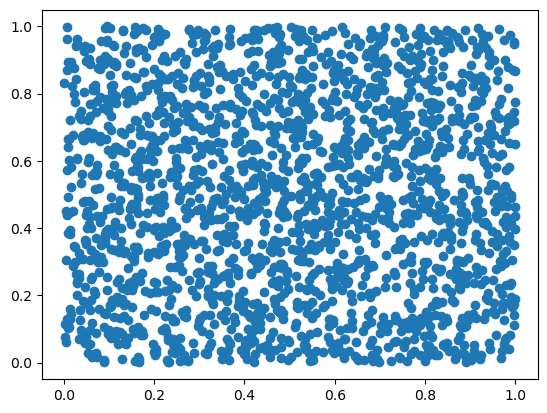

In [31]:
P=generate_points(2000)
k=1500

In [11]:
Q1=naive_algorithm(P,0,k,True)

Runtime: 4.234203100204468 seconds


In [32]:
Q2=efficient_algorithm(P,0,k,True)


Runtime: 2.4829087257385254 seconds


In [13]:
Q3=efficient_algorithm_smallk(P,0,k,True)

Runtime: 0.1199498176574707 seconds


In [14]:
Q1==Q2==Q3

True

### Task 4:
Lorsque $k$ devient plus grand, itérer sur tous les éléments de $S$ devient trop coûteux.

Trouver $p_i$. Au lieu de chercher répétitivement l'élément de $S$ avec le rayon maximal en temps linéaire, il peut être plus efficace de stocker les éléments de $S$ dans une structure de données qui permet un accès rapide à celui avec le rayon maximal.

Pour cet algorithme , on a implementé un tas ***MaxHeap*** afin d'extraire le max plus rapidement et aussi de pouvoir changer les priorite des elements en mettant à jour le tas à chaque fois .


***Mise à jour***. Nous pouvons stocker, pour chaque centre $s$, une liste d'*amis*, c'est-à-dire d'autres centres $t_1, \ldots, t_{js}$ dans $S$ qui sont assez proches de $s$ pour que si l'algorithme choisit un nouveau centre $p_i$ qui avait $s$ comme son centre au temps $i - 1$ (nous appelons $s$ le parent de $p_i$), alors tous les points qui ont $p_i$ comme leur nouveau centre au temps $i$ avaient soit $s$ soit l'un des $t_j$ comme leur centre au temps $i - 1$, donc nous avons seulement besoin de vérifier si ces points changent de région. Cela fonctionne toujours si le graphe d'amis est conservativement plus grand que strictement nécessaire (dans le cas extrême le graphe complet), bien que nous voulions le garder raisonnablement petit pour l'efficacité.

In [15]:
class MaxHeap:

    """
    Une classe représentant une structure de données Max heap.

    Attributs :
    - heap : Une liste représentant le tas.
    - key_position_map : Un dictionnaire mappant les clés à leurs positions dans le tas.

    Méthodes :
    - parent(i) : Retourne l'indice du nœud parent du nœud à l'indice i.
    - left_child(i) : Retourne l'indice du nœud enfant gauche du nœud à l'indice i.
    - right_child(i) : Retourne l'indice du nœud enfant droit du nœud à l'indice i.
    - sift_up(i) : Déplace le nœud à l'indice i vers le haut du tas pour maintenir la propriété de tas.
    - sift_down(i) : Déplace le nœud à l'indice i vers le bas du tas pour maintenir la propriété de tas.
    - insert(key, value) : Insère une nouvelle paire clé-valeur dans le tas ou met à jour la valeur si la clé existe déjà.
    - insertnew(key, value) : Insère une nouvelle paire clé-valeur dans le tas.
    - extract_max() : Supprime et retourne la paire clé-valeur avec la valeur maximale du tas.
    - delete(key) : Supprime la paire clé-valeur avec la clé spécifiée du tas.
    - replace(key, value) : Remplace la valeur de la paire clé-valeur avec la clé spécifiée dans le tas.
    - heapify(arr) : Convertit une liste de paires clé-valeur en un tas valide.
    """

    def __init__(self):
        self.heap = []
        self.key_position_map = {}  # clé --> valeur

    def parent(self, i):
        return (i - 1) // 2

    def left_child(self, i):
        return 2 * i + 1

    def right_child(self, i):
        return 2 * i + 2

    def sift_up(self, i):
        while i > 0 and self.heap[self.parent(i)][1] < self.heap[i][1]:
            self.key_position_map[self.heap[i][0]] = self.parent(i)
            self.key_position_map[self.heap[self.parent(i)][0]] = i
            self.heap[self.parent(i)], self.heap[i] = self.heap[i], self.heap[self.parent(i)]
            i = self.parent(i)

    def sift_down(self, i):
        max_index = i
        l = self.left_child(i)
        if l < len(self.heap) and self.heap[l][1] > self.heap[max_index][1]:
            max_index = l
        r = self.right_child(i)
        if r < len(self.heap) and self.heap[r][1] > self.heap[max_index][1]:
            max_index = r
        if i != max_index:
            self.key_position_map[self.heap[i][0]] = max_index
            self.key_position_map[self.heap[max_index][0]] = i
            self.heap[i], self.heap[max_index] = self.heap[max_index], self.heap[i]
            self.sift_down(max_index)
    def insert(self, key, value):
        if key in self.key_position_map:
            self.replace(key, value)
        else:
            self.insertnew(key, value)
    def insertnew(self, key, value):
        self.heap.append((key, value))
        self.key_position_map[key] = len(self.heap) - 1
        self.sift_up(len(self.heap) - 1)

    def extract_max(self):
        if len(self.heap) == 0:
            return None
        max_element = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.key_position_map[self.heap[-1][0]] = 0
        del self.key_position_map[max_element[0]]
        del self.heap[-1]
        if self.heap:
            self.sift_down(0)
        return max_element

    def delete(self, key):
        if key in self.key_position_map:
            i = self.key_position_map[key]
            self.heap[i] = (self.heap[i][0], float('-inf'))
            self.sift_up(i)
            self.extract_max()

    def replace(self, key, value):
        if key in self.key_position_map:
            i = self.key_position_map[key]
            old_value = self.heap[i][1]
            self.heap[i] = (key, value)
            if value > old_value:
                self.sift_up(i)
            else:
                self.sift_down(i)

    def heapify(self, arr):
        self.heap = arr
        self.key_position_map = {key: i for i, (key, value) in enumerate(arr)}
        n = len(arr)
        for i in range(n // 2 - 1, -1, -1):
            self.sift_down(i)


In [16]:

heap = MaxHeap()
heap.insert("A", 5)
heap.insert("B", 3)
heap.insert("C", 8)
heap.insert("D", 2)
heap.insert("E", 10)

print("Max heap après les insertions:", heap.heap)

print("Élément maximum extrait:", heap.extract_max())

print("Max heap après l'extraction :", heap.heap)

heap.insert("B", 12)
print("Max heap après le remplacement:", heap.heap)


Max heap après les insertions: [('E', 10), ('C', 8), ('A', 5), ('D', 2), ('B', 3)]
Élément maximum extrait: ('E', 10)
Max heap après l'extraction : [('C', 8), ('B', 3), ('A', 5), ('D', 2)]
Max heap après le remplacement: [('B', 12), ('C', 8), ('A', 5), ('D', 2)]


#### Remarquons qu'on peut améliorer l'algorithme 3 en utilisant un tas pour stocker les distances de chaque point à son centre. Cela permet de trouver le point le plus éloigné en temps constant et d'ajouter des points en temps logarithmique.

In [74]:
def efficient_algorithm_smallk_heap(P, i, k, runtime=False):
    
    """
    Task 3 avec Maxheap

    Paramètres:
    P (list): Liste de points.
    i (int): Indice du centre initial.
    k (int): Nombre de centres à sélectionner.
    runtime (bool, facultatif): Indicateur pour afficher le temps d'exécution de l'algorithme.

    Variables:
    centers (list): Liste d'indices représentant les centres sélectionnés.
    regions (dict): Dictionnaire contenant les régions de chaque centre.
    radii_elt (dict): Dictionnaire contenant ,pour chaque centre, l'indice du point le plus éloigné de sa région.
    radii (MaxHeap): Tas contenant, pour chaque centre, le rayon de sa région.
    friends (dict): Dictionnaire contenant les amis de chaque centre.


    Retourne:
    list: Liste d'indices représentant les centres sélectionnés.
    """

    start_time = time.time()
    centers = [i]

    regions = {i: {j for j in range(len(P)) if j != i}} # O(n) construction du set
    radii_elt = {i: max({j for j in range(len(P)) if j != i}, key=lambda x: normy(P[x], P[i]))} # O(n) pour le maximum
 
    radii = MaxHeap()
    radii.insert(i, normy(P[radii_elt[i]], P[i])) # O(1) mais L'insertion dans MaxHeap se fait en O(log(n)) en general

    ratio = 2 # ratio doit etre >2

    for _ in range(k - 1):
        center, _ = radii.extract_max()
        farthest_point = radii_elt[center]

        centers.append(farthest_point)
        stolen_points = set()

        far_radius = 0
        far_radii_elt = farthest_point

    
        for cen , region in regions.items(): 
            if not regions[cen]:
                continue

            center_new_radius = 0
            center_new_radii_elt = cen
            region_copy = regions[cen].copy()


            for j in region_copy:
                cur_distance = normy(P[j], P[cen])
                far_j_distance = normy(P[j], P[farthest_point])

                if cur_distance > far_j_distance:
                    regions[cen].remove(j)
                    stolen_points.add(j)





                    if far_j_distance > far_radius:
                        far_radius = far_j_distance
                        far_radii_elt = j
                else:
                    if cur_distance > center_new_radius:
                        center_new_radius = cur_distance
                        center_new_radii_elt = j





            radii.insert(cen, center_new_radius)
            radii_elt[cen] = center_new_radii_elt



        regions[farthest_point] = stolen_points
        radii.insert(farthest_point, far_radius)
        radii_elt[farthest_point] = far_radii_elt



    end_time = time.time()
    run = end_time - start_time
    if runtime:
        print(f"Runtime: {run} seconds")
    return centers


### Algorithme pour grands k:

La logique d'amitié entre les centres est la suivante:
Elle n'est pas commutative , et $S_2$ est ami de $S_1$ si $\text{distance}(s_1, s_2) - \text{rayon}(s_1) \leq 2 \times \text{rayon}(s_2)$. Cette condition est nécessaire.

In [68]:
def efficient_algorithm_bigk(P, i, k,runtime=True):
    """
    Algorithme plus efficace pour des k grands ( O(n + fklog(k)) avec f la borne sup du nombre d'amis) pour sélectionner k centres à partir d'un ensemble de points.
    Cette version est optimisée pour les petits k.

    Paramètres:
    P (list): Liste de points.
    i (int): Indice du centre initial.
    k (int): Nombre de centres à sélectionner.
    runtime (bool, facultatif): Indicateur pour afficher le temps d'exécution de l'algorithme.

    Variables:
    centers (list): Liste d'indices représentant les centres sélectionnés.
    regions (dict): Dictionnaire contenant les régions de chaque centre.
    radii_elt (dict): Dictionnaire contenant ,pour chaque centre, l'indice du point le plus éloigné de sa région.
    radii (MaxHeap): Tas contenant, pour chaque centre, le rayon de sa région.
    friends (dict): Dictionnaire contenant les amis de chaque centre.


    Retourne:
    list: Liste d'indices représentant les centres sélectionnés.
    """
    start_time = time.time()
    centers = [i]
    regions = {i: {j for j in range(len(P)) if j != i}}# O(n) construction du set
    radii_elt = {i : max({j for j in range(len(P)) if j != i}, key=lambda x: normy(P[x], P[i]))} # O(n) pour le maximum
    radii = MaxHeap()
    radii.insert(i, normy(P[radii_elt[i]], P[i])) # O(1) mais L'insertion dans MaxHeap se fait en O(log(n)) en general
    friends = {i: {i}}
    for _ in range(k - 1):

        center, _ = radii.extract_max() # O(1)
        farthest_point = radii_elt[center]
        stolen_points = set()
        far_radius = -1
        far_radii_elt = farthest_point
        new_farthest_friends={farthest_point}

        friends_copy = friends[center].copy() # car on change friends[center] dans la boucle

        for cen in friends_copy:
            center_new_radius = 0
            center_new_radii_elt = cen
            region_copy = regions[cen].copy()
            voler = False
            for j in region_copy:
                cur_distance = normy(P[j], P[cen])
                far_j_distance = normy(P[j], P[farthest_point])
                if cur_distance > far_j_distance:
                    voler=True
                    regions[cen].remove(j)
                    stolen_points.add(j)
                    if far_j_distance > far_radius:
                        far_radius = far_j_distance
                        far_radii_elt = j
                else:
                    if cur_distance > center_new_radius:
                        center_new_radius = cur_distance
                        center_new_radii_elt = j
            if voler:
              friends[cen].add(farthest_point)
            radii.insert(cen, center_new_radius)
            radii_elt[cen] = center_new_radii_elt

        centers.append(farthest_point)
        regions[farthest_point] = stolen_points
        radii.insert(farthest_point, far_radius)
        radii_elt[farthest_point] = far_radii_elt
        for j in centers:
          if j!= farthest_point:

            if normy(P[farthest_point],P[j])- normy(P[j],P[radii_elt[j]])<2* normy(P[farthest_point],P[radii_elt[farthest_point]]):
                
                new_farthest_friends.add(j)
                friends[j].add(farthest_point)
        friends[farthest_point]=new_farthest_friends
    end_time = time.time()
    run = end_time - start_time
    if runtime:
        print(f"Runtime: {run} seconds")
    return centers

In [70]:
Q4=efficient_algorithm_bigk(P, 0, k)
Q3=efficient_algorithm_smallk(P, 0, k,True)

print(f"Test d'égalité{ Q3==Q4}")


Runtime: 1.8259453773498535 seconds
Runtime: 9.761932134628296 seconds
Test d'égalitéTrue


**Complexité:**

Notons $C$ la complexité de l'algorithme.

On a $C = 2n + \sum_{i=1}^{k-1} F(i) \cdot (\log(i) + O(1)) = O(n + \sum_{i=1}^{k-1} F(i) \log(i))$ où $F(i)$ est le nombre d'amis de l'ancien centre au temps $i$.

Si on suppose que le nombre d'amis est borné par $f$, c'est-à-dire $F(i) \leq f$, alors

$C \leq n + f \sum_{i=1}^{k-1} \log(i) \leq O(n + f k \log(k))$

## Application 1: Retrouvons la cible

La capacité de se disperser rapidement dans un ensemble de points de cet algorithme nous a fait penser à la question suivante : est-ce mieux de chercher une cible dans un ensemble de points aléatoirement ou par un échantillonnage progressif ?

Si on considère un graphique avec des points bleus formant un rectangle et un cercle localisé quelque part, coloré en jaune et considéré comme cible, on cherche la probabilité de trouver cette cible pour des valeurs initiales de l'algorithme d'échantillonnage prises au hasard.

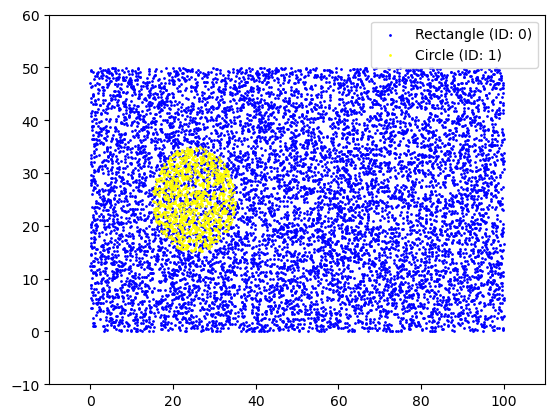

In [20]:
def generate_rectangle_points_with_id(bottom_left, width, height, num_points=10000):
    x = np.random.uniform(bottom_left[0], bottom_left[0] + width, num_points)
    y = np.random.uniform(bottom_left[1], bottom_left[1] + height, num_points)
    ids = np.zeros(num_points)
    return list(zip(x, y, ids))

def generate_circle_points_with_id(center, radius, num_points=1000):
    angles = np.random.uniform(0, 2 * np.pi, num_points)
    r = radius * np.sqrt(np.random.uniform(0, 1, num_points))
    x = center[0] + r * np.cos(angles)
    y = center[1] + r * np.sin(angles)
    ids = np.ones(num_points)
    return list(zip(x, y, ids))

rectangle_points_with_id = generate_rectangle_points_with_id((0, 0), 100, 50)
circle_points_with_id = generate_circle_points_with_id((25, 25), 10)
combined_points = rectangle_points_with_id + circle_points_with_id
fig, ax = plt.subplots()
rect_x, rect_y, _ = zip(*rectangle_points_with_id)
circle_x, circle_y, _ = zip(*circle_points_with_id)
ax.scatter(rect_x, rect_y, color='blue', s=1, label='Rectangle (ID: 0)')
ax.scatter(circle_x, circle_y, color='yellow', s=1, label='Circle (ID: 1)')
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 60)
ax.legend()
plt.show()


In [21]:
import random
def separate_points_by_id(points_with_id):
    points_by_id = {}
    points_by_id[1]=[]
    for point in points_with_id:
        point_id = point[2]
        if point_id not in points_by_id:
            points_by_id[point_id] = []
        points_by_id[point_id].append(point)
    return points_by_id
def apply_filter_with_id(points_with_id, filter_function):
    i=random.randint(0,len(points_with_id))
    only_coordinates = [point[:2] for point in points_with_id]
    X=efficient_algorithm(only_coordinates,i,10)
    Y=[only_coordinates[i] for i in X]
    filtered_coordinates = set(Y)
    return [point for point in points_with_id if point[:2] in filtered_coordinates]



In [22]:
#On doit répéter l'expérience beacoup de fois 
n=8  # le 8 est pour vérifier que tout marche bien, la courbe de la proba est dans le rapport 
S=0
for i in range(n):
  filtered_points_with_id = apply_filter_with_id(combined_points, efficient_algorithm)
  separeted=separate_points_by_id(filtered_points_with_id )
  if (len(separeted[1])!=0):
    S+=1
print("la proba est :", S/n)

la proba est : 0.625


Etonnement , la forte delocalisation de l'algo n'est finalement pas un point fort pour lui permettre de retrouver une cible lorsqu'on compare ses performance avec un modele de recherche aleatoire notre algorithme fait defaut

## Application 2: Nous en minimaliste

L'algorithme permet de reduire efficacement un ensemble de data a un sous ensemble qui garde les propietés de l'original. Amusons nous en lui demandant de garder reconnaissable les data set suivants


Pour une bonne resolution on conseille de choisir n=500 mais cela risque de prendre du temps vu la taille de la dataset. une image pour n grand est presente sur le rapport.

In [23]:
from PIL import Image


def generate(image_path, threshold=100, scale=2):
    img = Image.open(image_path).convert('L')
    img = img.resize((int(img.width * scale), int(img.height * scale)))
    points = []
    for x in range(img.width):
        for y in range(img.height):
            if img.getpixel((x, y)) < threshold:
                points.append((x, -y))
    return points


### Chat

48738


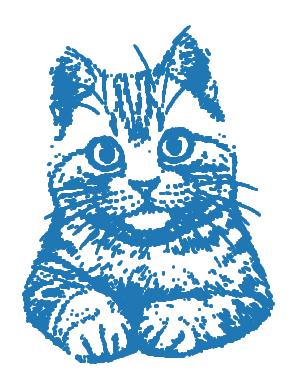

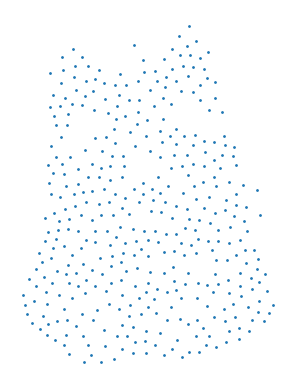

In [24]:
image_path = 'images/cat2.jpg'
points = generate(image_path, scale=2)
print(len(points))
plt.scatter(*zip(*points), s=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()
P=[points[i] for i in efficient_algorithm_smallk(points,0,400)]
plt.scatter(*zip(*P), s=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

48738


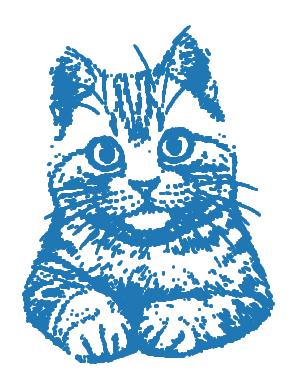

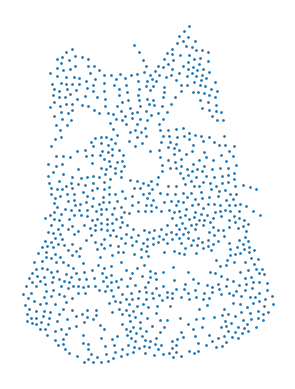

In [25]:
image_path = 'images/cat2.jpg'
points = generate(image_path, scale=2)
print(len(points))
plt.scatter(*zip(*points), s=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()
P=[points[i] for i in efficient_algorithm_smallk(points,0, 1000)]
plt.scatter(*zip(*P), s=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

### Tour Eiffel

76711


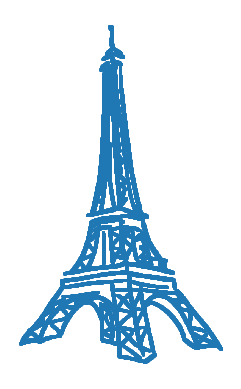

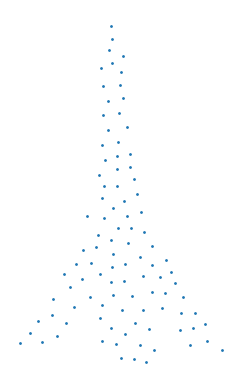

In [25]:
# Chemin vers une image de la Tour Eiffel
image_path = 'images/eiffel.jpg'

# Générer les points
points = generate(image_path, scale=2)
print(len(points))
# Tracer les points
plt.scatter(*zip(*points), s=1)  # s contrôle la taille des points
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()
P=[points[i] for i in efficient_algorithm(points,0,100)]  # les algorithmes retournes les indices des points
plt.scatter(*zip(*P), s=1)  # s contrôle la taille des points
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

Runtime: 3.656940460205078 seconds
Runtime: 6.811319589614868 seconds
Runtime: 35.296642780303955 seconds


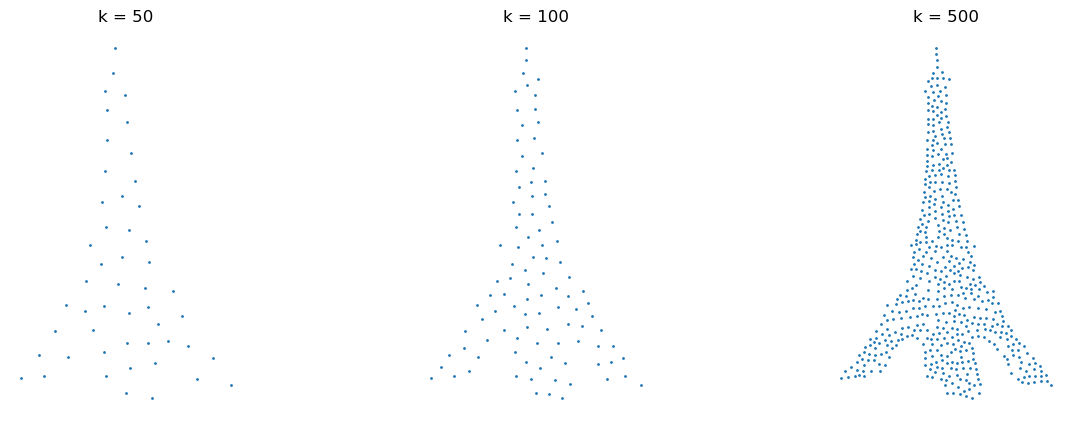

In [26]:
# Comparaison pour 3 sous-echantillons
plt.figure(figsize=(15, 5))


m_values = [50,100, 500]

for i, m in enumerate(m_values, start=1):

    P = [points[i] for i in efficient_algorithm_smallk(points, 0, m,True)]


    plt.subplot(1, len(m_values), i)
    plt.title(f'k = {m}')
    plt.scatter(*zip(*P), s=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')


plt.show()

## Application 3: Lissage de surface et de courbe

Runtime: 0.32744860649108887 seconds


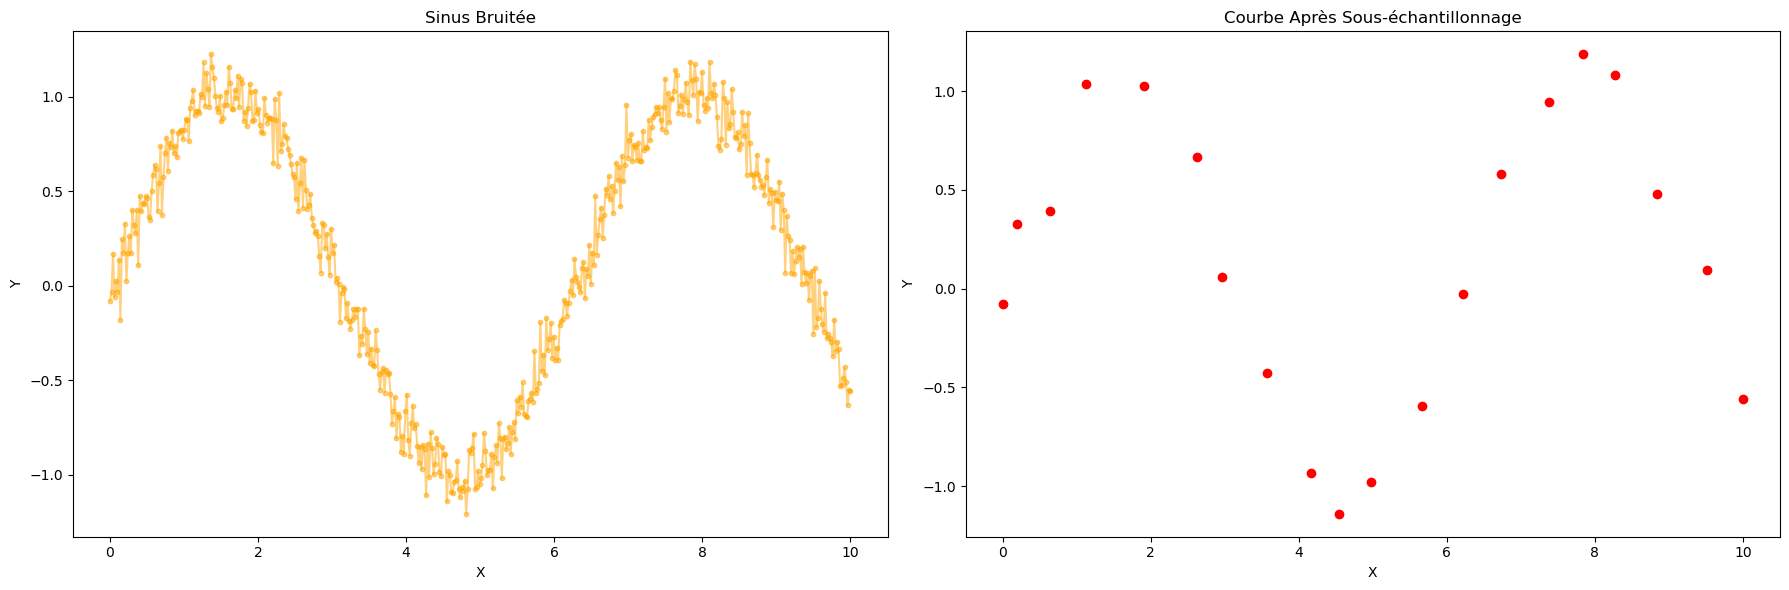

In [27]:


# Générer 1000 points uniformément distribués sur l'axe des x
x_uniform = np.linspace(0, 10, 500)
# Fonction sinus
y_function = np.sin(x_uniform)
# Ajouter un bruit gaussien
y_function_bruite = y_function + np.random.normal(0, 0.1, y_function.shape)


Points = list(zip(x_uniform, y_function_bruite))

# Algorithme de sous-échantillonnage sur les Points

# Appliquer l'algorithme de sous-échantillonnage
Points_sous_echantillonnes = [Points[i] for i in efficient_algorithm(Points, 0, 20,True)]


x_sous_echantillon, y_sous_echantillon = zip(*Points_sous_echantillonnes)


plt.figure(figsize=(18, 6))

# Courbe originale avec bruit
plt.subplot(1, 2, 1)
plt.plot(x_uniform, y_function_bruite, 'orange', alpha=0.5, label='Courbe Bruitée')
plt.scatter(x_uniform, y_function_bruite, color='orange', s=10, alpha=0.5)
plt.title('Sinus Bruitée')
plt.xlabel('X')
plt.ylabel('Y')

# Courbe après sous-échantillonnage
plt.subplot(1, 2, 2)
plt.scatter(x_sous_echantillon, y_sous_echantillon, color='red', label='Après Sous-échantillonnage')

plt.title('Courbe Après Sous-échantillonnage')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()



# Section 2: Neighborhood
## Introduction

## Résumé sur la Construction de Graphes à partir d'un Ensemble de Points

Formellement, dans un espace de dimension $d$, pour un ensemble $P$ de $n$
points, un graphe $G$ est construit. Chaque point dans $P$ correspond à un sommet dans $G$, et deux sommets $p_i$ et $p_j$ sont connectés si aucun autre point $p_k \in P$ n'empêche la connexion directe entre $p_i$ et $p_j$, selon le critère $\max(d(p_i, p_k), d(p_j, p_k)) < d(p_i, p_j)$.


Nous allons d'abord proposer une version naïve de l'algorithme, puis nous essaierons de l'améliorer, pour finalement proposer un lien avec *le sampling* de la partie 1.


### Task 5:

In [28]:
import itertools

def distance(point1, point2):
    """Calcule la distance euclidienne entre deux points."""
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

class Graph:
    def __init__(self):
        self.sommet = []
        self.graph = {}

    def ajout(self, P):
        """Ajoute une liste de points au graphe."""
        for point in P:
            self.sommet.append(point)

    def relier(self, point1, point2): # condition d eliaison entre deuc elemets
        """Vérifie si un lien doit être créé entre deux points."""
        d12 = distance(point1, point2)
        for point in self.sommet:
            if point != point1 and point != point2:
                if max(distance(point1, point), distance(point2, point)) < d12:
                    return False
        return True

    def create_graph(self):
        for point1, point2 in itertools.combinations(self.sommet, 2):
            if self.relier(point1, point2):
                if point1 not in self.graph:
                    self.graph[point1] = []
                if point2 not in self.graph:
                    self.graph[point2] = []
                self.graph[point1].append(point2)
                self.graph[point2].append(point1)
    def actualise(self, nouveau_point): # elle construit les voisin d'un element quand on souhaite remplir le graphe point par point
        if nouveau_point not in self.sommet:
            self.sommet.append(nouveau_point)
        self.graph[nouveau_point] = []
        for point_existant in self.sommet:
            if point_existant != nouveau_point and self.relier(nouveau_point, point_existant):
                if point_existant not in self.graph:
                    self.graph[point_existant] = []
                self.graph[nouveau_point].append(point_existant)
                self.graph[point_existant].append(nouveau_point)

    def get_sommet(self):
        return self.sommet


In [30]:

def generer_points_aleatoires(n):
    max_val=100
    points = [(random.uniform(0,100),random.uniform(0,100)) for i in range(n)]
    return list(set(points))



In [31]:

n = 200
points_aleatoires = generer_points_aleatoires(n)
graph = Graph()
graph.ajout(points_aleatoires)
graph.create_graph()
created_graph = graph.graph

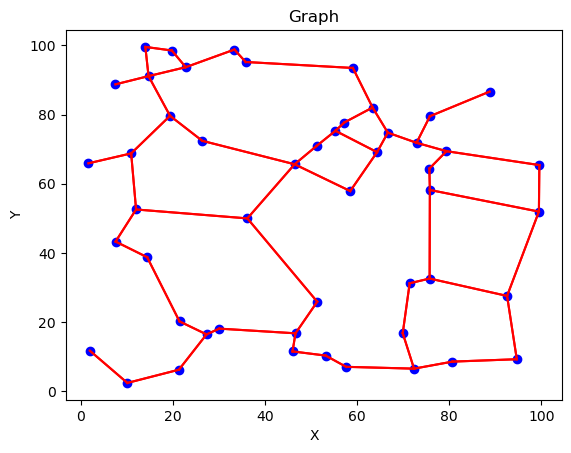

In [32]:
def visualiser_graphe(graph): # Cette fonction nous permettera de dessiner des graphes si besoin
    plt.figure()
    for point, voisins in graph.items():
        x, y = point
        plt.scatter(x, y, color='blue')
        for voisin in voisins:
            voisin_x, voisin_y = voisin
            plt.plot([x, voisin_x], [y, voisin_y], color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Graph')
    plt.show()
n=50
P = generer_points_aleatoires(n)
graph = Graph()
graph.ajout(P)
graph.create_graph()
visualiser_graphe(graph.graph)



### Task 6

Cette méthode vise à identifier tous les voisins d'un point spécifique $p$ dans un ensemble $P$, avec une efficacité temporelle de $O(n)$. Initialement, à partir de l'ensemble $P \setminus \{p\}$, le point $q$, étant le plus proche de $p$, est immédiatement considéré comme un voisin de $p$. Il est important de noter que, pour un quelconque point $r \in P \setminus \{p, q\}$, $q$ ne permet à $r$ d'être un voisin de $p$ que si la distance de $r$ à $p$ est supérieure à celle de $r$ à $q$. Ainsi, tous les points $r$ qui sont plus proches de $q$ que de $p$ sont écartés. Ce processus est répété avec les points restants, en cherchant systématiquement le point le plus proche de $p$, jusqu'à épuisement des points.

Bien que cet algorithme tende à générer un ensemble restreint de points, à savoir $O(1)$ (représentant les points les plus proches), l'analyse ne s'arrête pas là. La liste obtenue, bien qu'incluant tous les voisins potentiels, peut également contenir des points non pertinents. En effet, certains points écartés dans les premières étapes pourraient influencer la détermination des voisins dans les étapes ultérieures. Il est donc nécessaire d'effectuer une vérification supplémentaire sur ces candidats $O(1)$ pour confirmer leur statut de voisin, soit par une approche de force brute examinant l'interaction avec les autres points de $P$, soit en intégrant cette vérification dans le processus initial pour garantir la même logique opérationnelle.




In [33]:
def clean(liste_triee,proche,x): # debarasse la liste des elements qui ne peuvent jamais etre voisin de x à cause de proche
  L=[]
  n=len(liste_triee)
  for i in range(1,n):
    point=liste_triee[i]
    if distance(proche, point) >= distance(point, x):
      L.append(point)
  return L

In [34]:

class Graph20:
    def __init__(self):
        self.sommet = []
        self.graph = {}

    def ajout(self, P):
        """Ajoute une liste de points au graphe."""
        for point in P:
            self.sommet.append(point)
            self.graph[point] = []
        return True
    


    def voisin(self,x):
      P=self.sommet.copy()
      P.remove(x)
      liste_triee = sorted(P, key=lambda t: distance(t, x)) # On trie une fois pour tout les elements de P par leur distance à x
      L=[] # liste des voisins
      adj=[] # liste finale des voisins
      while len(liste_triee)!=0:
        proche=liste_triee[0] # On choisit le plus proche
        L.append(proche)
        liste_triee=clean(liste_triee,proche,x) # clean la liste des intrus
      for voisin in L: # checker par la force si tous les voisin le sont vraiment
        d12=distance(voisin, x)
        check=True
        for z in self.sommet:
          if max(distance(voisin, z), distance(z, x)) < d12:
            check=False
            break
        if check:
          adj.append(voisin)
          if x not in self.graph[voisin]:
            self.graph[voisin].append(x)
      return(adj)
    

    # Actualise  : Task 7 pour ajouter un point en temps linéaire
    def actualise(self, nouveau_point):
      self.sommet.append(nouveau_point)
      self.graph[nouveau_point] = self.voisin(nouveau_point)
      for center in self.sommet:
        edge = True
        for point in self.graph[center]:
            if max(distance(point, nouveau_point), distance(center, nouveau_point)) < distance(center, point):
                edge = False
                break
        if not edge:
            self.graph[center].remove(point)
            if center in self.graph[point]:
              self.graph[point].remove(center)
      return True
    



    def create_graph(self):
        """Crée la structure du graphe."""
        for point in self.sommet:
            self.graph[point]=self.voisin(point)




    def get_sommet(self):
        """Retourne les sommets du graphe."""
        return self.sommet


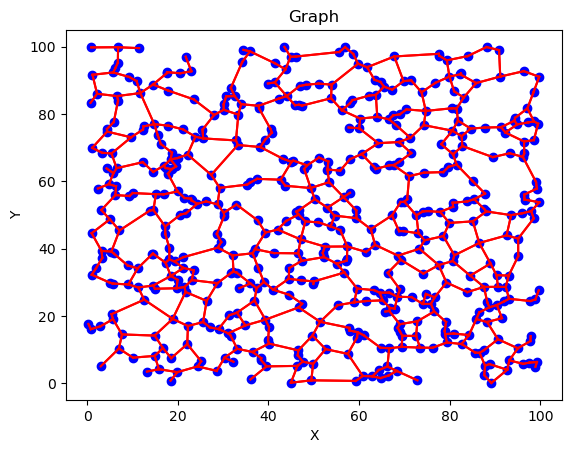

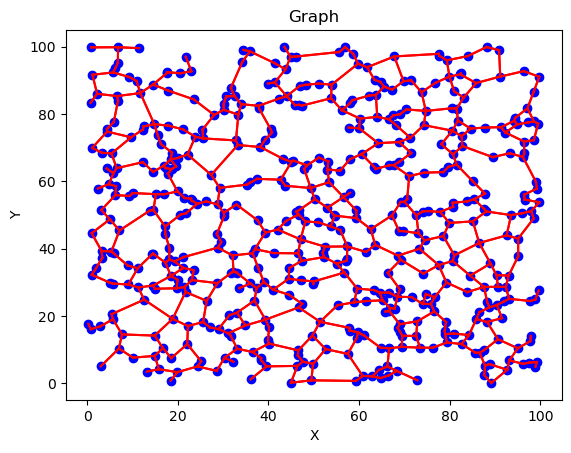

test de validité : True


In [35]:

n = 500 # Nombre de points à générer
points_aleatoires = generer_points_aleatoires(n)
graph = Graph20()
graph.ajout(points_aleatoires)
graph.create_graph()
g1 = graph.graph
visualiser_graphe(graph.graph)
graph2 = Graph()
graph2.ajout(points_aleatoires)
graph2.create_graph()
g2 = graph2.graph
visualiser_graphe(graph2.graph)
def normaliser_graphe(graphe):
    for sommet, voisins in graphe.items():
        for voisin in voisins:
            if sommet not in graphe[voisin]:
                for sommet in graphe:
                    graphe[sommet] = sorted(set(graphe[sommet]))
    return graphe

def sont_identiques(graphe1, graphe2):
    graphe1 = normaliser_graphe(graphe1)
    graphe2 = normaliser_graphe(graphe2)

    if set(graphe1.keys()) != set(graphe2.keys()):
        return False

    for sommet in graphe1:
        if set(graphe1[sommet]) != set(graphe2.get(sommet, [])):
            return False

    return True
print("test de validité :",sont_identiques(g1, g2))


### Task 7
La fonction ```Actualise``` ajoutée au graph permet d'ajouter un point en temps linéaire :

```python
    def actualise(self, nouveau_point):
      self.sommet.append(nouveau_point)
      self.graph[nouveau_point] = self.voisin(nouveau_point)
      for center in self.sommet:
        edge = True
        for point in self.graph[center]:
            if max(distance(point, nouveau_point), distance(center, nouveau_point)) < distance(center, point):
                edge = False
                break
        if not edge:
            self.graph[center].remove(point)
            if center in self.graph[point]:
              self.graph[point].remove(center)
      return True
``` 

### Task 8

Pour combiner les deux tâches 7 et 3, on peut remarquer qu'en utilisant la structure de graphe définie dans la deuxième partie du projet, ceci permettra d'éliminer davantage les éléments de $P \setminus S$ à contrôler.

En effet, lorsqu'on rajoute un point $q$ à $S$, on détermine avec la condition : $\text{normy}(P[\text{farthest\_point}], P[\text{cen}])  < 2 \times \text{radii}[\text{cen}]$ que les éléments attachés au centre $\text{cen}$ peuvent être des proies potentielles pour le nouveau centre.

La définition du graphe de la partie 2 permet d'affirmer l'équivalence suivante :
$x$ est voisin de $p$ si et seulement si il ne peut lui être détaché par un nouveau centre.

On va donc restreindre nos recherche aux non voisin de $p$


In [36]:
def sampling_graph(P, i, k): 
    G=Graph20()
    start_time = time.time()
    centers = [i]
    G.actualise(P[i])

    regions = {i: {j for j in range(len(P)) if j != i}}
    radii_elt = {i : max({j for j in range(len(P)) if j != i}, key=lambda x: normy(P[x], P[i]))}
    radii = {i: normy(P[radii_elt[i]], P[i])}

    for _ in range(k - 1):
        center = max(radii, key=radii.get)
        farthest_point = radii_elt[center]
        centers.append(farthest_point)
        stolen_points = set()
        far_radius = -1
        far_radii_elt = farthest_point

        for cen, region in regions.items():

            if not region:
                continue
            
            center_change_Flag=False
            
            if normy(P[farthest_point], P[cen]) < 2 * radii[cen]:
                center_change_Flag=True
                center_new_radius = -1
                center_new_radii_elt = cen
                region_copy = region.copy()
                
                for j in region_copy:
                    if P[j] not in G.graph[P[cen]]:
                      cur_distance = normy(P[j], P[cen])
                      far_j_distance = normy(P[j], P[farthest_point])
                      
                      if cur_distance > far_j_distance:
                          region.remove(j)
                          stolen_points.add(j)
                          if far_j_distance > far_radius:
                              far_radius = far_j_distance
                              far_radii_elt = j
                      else:
                          if cur_distance > center_new_radius:
                              center_new_radius = cur_distance
                              center_new_radii_elt = j
            
            if center_change_Flag:
                radii[cen] = center_new_radius
                radii_elt[cen] = center_new_radii_elt
            else: 
                radii_elt[cen] =  max(region, key=lambda x: normy(P[x], P[cen])) 
                radii[cen] = normy(P[radii_elt[cen]], P[cen])
        
        G.actualise(P[farthest_point])
        
        regions[farthest_point] = stolen_points
        radii[farthest_point] = far_radius
        radii_elt[farthest_point] = far_radii_elt
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Runtime: {runtime} seconds")
    return centers

testons cela

In [37]:
P=generer_points_aleatoires(5000)
Q4=sampling_graph(P,0,50)
Q3=naive_algorithm(P,0,50)
print(Q3==Q4)

Runtime: 0.5493061542510986 seconds
True


## Benchmarks


In [38]:
def generate_uniform_points(n, square_size=1):
    return [(x, y) for x, y in np.random.rand(n, 2) * square_size]

def generate_clustered_points(n, clusters= 2):
    return [(x, y) for x, y in make_blobs(n_samples=n, centers=clusters, n_features=2)[0]]

def generate_grid_points(grid_size):
    x = np.linspace(0, 1, int(sqrt(grid_size)))
    y = np.linspace(0, 1, int(sqrt(grid_size)))
    return [(x, y) for x, y in np.array(np.meshgrid(x, y)).T.reshape(-1, 2)]

def generate_gaussian_points(n, mean = [0,0], cov= [[1,0],[0,1]]):
    return [(x, y) for x, y in np.random.multivariate_normal(mean, cov, n)]

def generate_rectangular_dataset(width, height, n_points):

    top_edge = np.column_stack((np.linspace(0, width, n_points//4), np.full(n_points//4, height)))
    bottom_edge = np.column_stack((np.linspace(0, width, n_points//4), np.zeros(n_points//4)))
    left_edge = np.column_stack((np.zeros(n_points//4), np.linspace(0, height, n_points//4)))
    right_edge = np.column_stack((np.full(n_points//4, width), np.linspace(0, height, n_points//4)))


    rectangle = np.concatenate((top_edge, bottom_edge, left_edge, right_edge))

    return rectangle

def generate_noisy_rectangular_dataset(n_points, width = 10, height = 5,  noise_level = 0.3):
    # rectangle
    rectangle = generate_rectangular_dataset(width, height, n_points)

    # Bruit
    noise = np.random.normal(0, noise_level, rectangle.shape)
    noisy_rectangle = rectangle + noise

    return [(x, y) for x, y in noisy_rectangle]


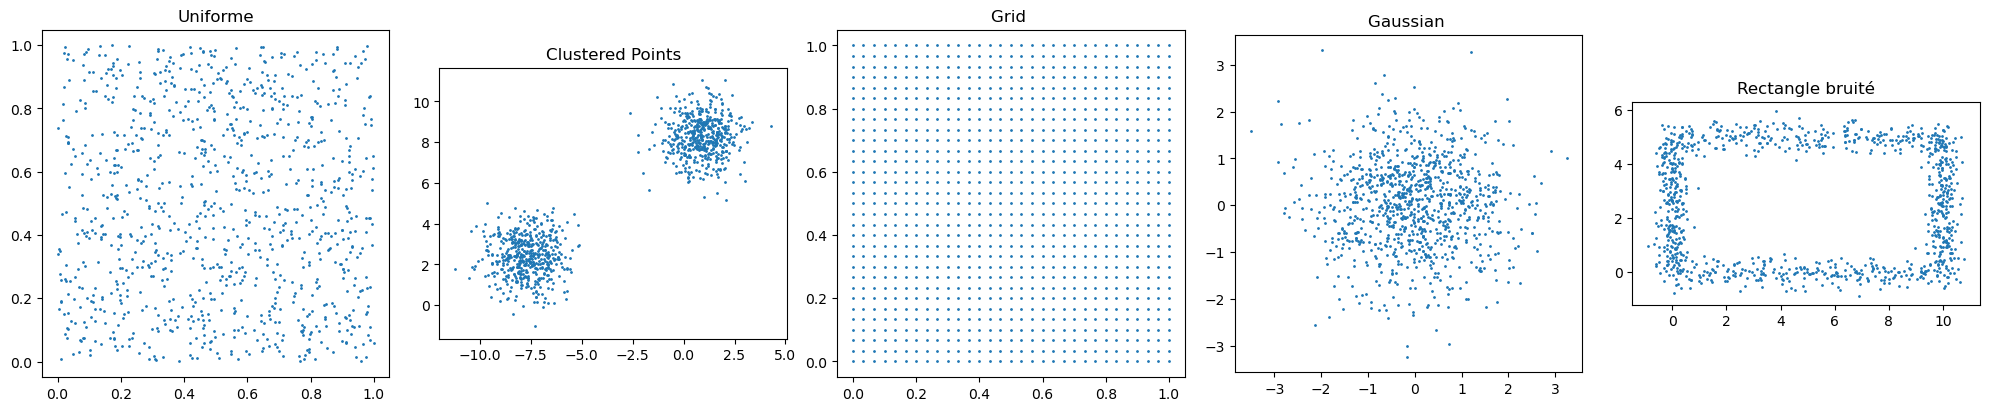

In [39]:
uniform_points = generate_uniform_points(1000)
clustered_points = generate_clustered_points(1000)
grid_points = generate_grid_points(1000)
gaussian_points = generate_gaussian_points(1000)
rectangular_points = generate_noisy_rectangular_dataset(1000)


fig, axs = plt.subplots(1, 5, figsize=(20, 4))


axs[0].scatter(*zip(*uniform_points), s=1)
axs[0].set_title('Uniforme')
axs[0].set_aspect('equal')

axs[1].scatter(*zip(*clustered_points), s=1)
axs[1].set_title('Clustered Points')
axs[1].set_aspect('equal')

axs[2].scatter(*zip(*grid_points), s=1)
axs[2].set_title('Grid ')
axs[2].set_aspect('equal')

axs[3].scatter(*zip(*gaussian_points), s=1)
axs[3].set_title('Gaussian ')
axs[3].set_aspect('equal')

axs[4].scatter(*zip(*rectangular_points), s=1)
axs[4].set_title('Rectangle bruité')
axs[4].set_aspect('equal')


plt.tight_layout()
plt.show()

Comparons les 4 algorithmes.

In [40]:
import pandas as pd


def benchmark_algorithm(algorithm, P, k):

    start_time = time.time()
    algorithm(P, 0, k)
    end_time = time.time()
    runtime = end_time - start_time
    return runtime

def benchmark_algorithms(n, k):
    algorithms = {
        "naive": naive_algorithm,
        "efficient": efficient_algorithm,
        "efficient_smallk": efficient_algorithm_smallk,
        "efficient_bigk": efficient_algorithm_bigk
    }

    datasets = {
        "uniform": generate_uniform_points ,
        "clustered": generate_clustered_points,
        "grid": generate_grid_points,
        "gaussian": generate_gaussian_points,
        "noisy_rectangular": generate_noisy_rectangular_dataset
    }

    results = {}
    for algorithm_name, algorithm in algorithms.items():
        print(algorithm_name)
        row = {}
        for dataset_name, dataset_function in datasets.items():
            print(dataset_name)
            P = dataset_function(n)
            runtime = benchmark_algorithm(algorithm, P, k)
            row[dataset_name] = runtime
            normy.cache_clear() #pour vider le cache
        results[algorithm_name] = row
        
    return pd.DataFrame(results)



In [41]:
df=benchmark_algorithms(100, 50)
df

naive
uniform
clustered
grid
gaussian
noisy_rectangular
efficient
uniform
clustered
grid
gaussian
noisy_rectangular
efficient_smallk
uniform
clustered
grid
gaussian
noisy_rectangular
efficient_bigk
uniform
clustered
grid
gaussian
noisy_rectangular


,naive,efficient,efficient_smallk,efficient_bigk
uniform,0.256280,0.002732,0.004053,0.004323
clustered,0.040235,0.002497,0.003518,0.004694
grid,0.040258,0.002374,0.003700,0.007565
gaussian,0.046099,0.002873,0.005422,0.005969
noisy_rectangular,0.041345,0.003704,0.003649,0.004290


In [42]:
df=benchmark_algorithms(1000, 50)
df

naive
uniform
clustered
grid
gaussian
noisy_rectangular
efficient
uniform
clustered
grid
gaussian
noisy_rectangular
efficient_smallk
uniform
clustered
grid
gaussian
noisy_rectangular
efficient_bigk
uniform
clustered
grid
gaussian
noisy_rectangular


,naive,efficient,efficient_smallk,efficient_bigk
uniform,0.445550,0.072819,0.056783,0.088298
clustered,0.444384,0.072214,0.063364,0.107601
grid,0.451936,0.069149,0.050311,0.099347
gaussian,0.665619,0.077426,0.059325,0.115149
noisy_rectangular,0.808913,0.071464,0.049792,0.066383


In [43]:
df=benchmark_algorithms(1000, 300)
df

naive
uniform
clustered
grid
gaussian
noisy_rectangular
efficient
uniform
clustered
grid
gaussian
noisy_rectangular
efficient_smallk
uniform
clustered
grid
gaussian
noisy_rectangular
efficient_bigk
uniform
clustered
grid
gaussian
noisy_rectangular


,naive,efficient,efficient_smallk,efficient_bigk
uniform,40.333086,0.403157,0.417747,0.228504
clustered,34.041219,0.439012,0.446190,0.253888
grid,29.256016,0.470698,0.490613,0.230541
gaussian,30.640978,0.472149,0.482225,0.294409
noisy_rectangular,32.415050,0.428818,0.405749,0.159050


### Afficher les datasets et les résultats de l'algorithme pour chaque dataset.

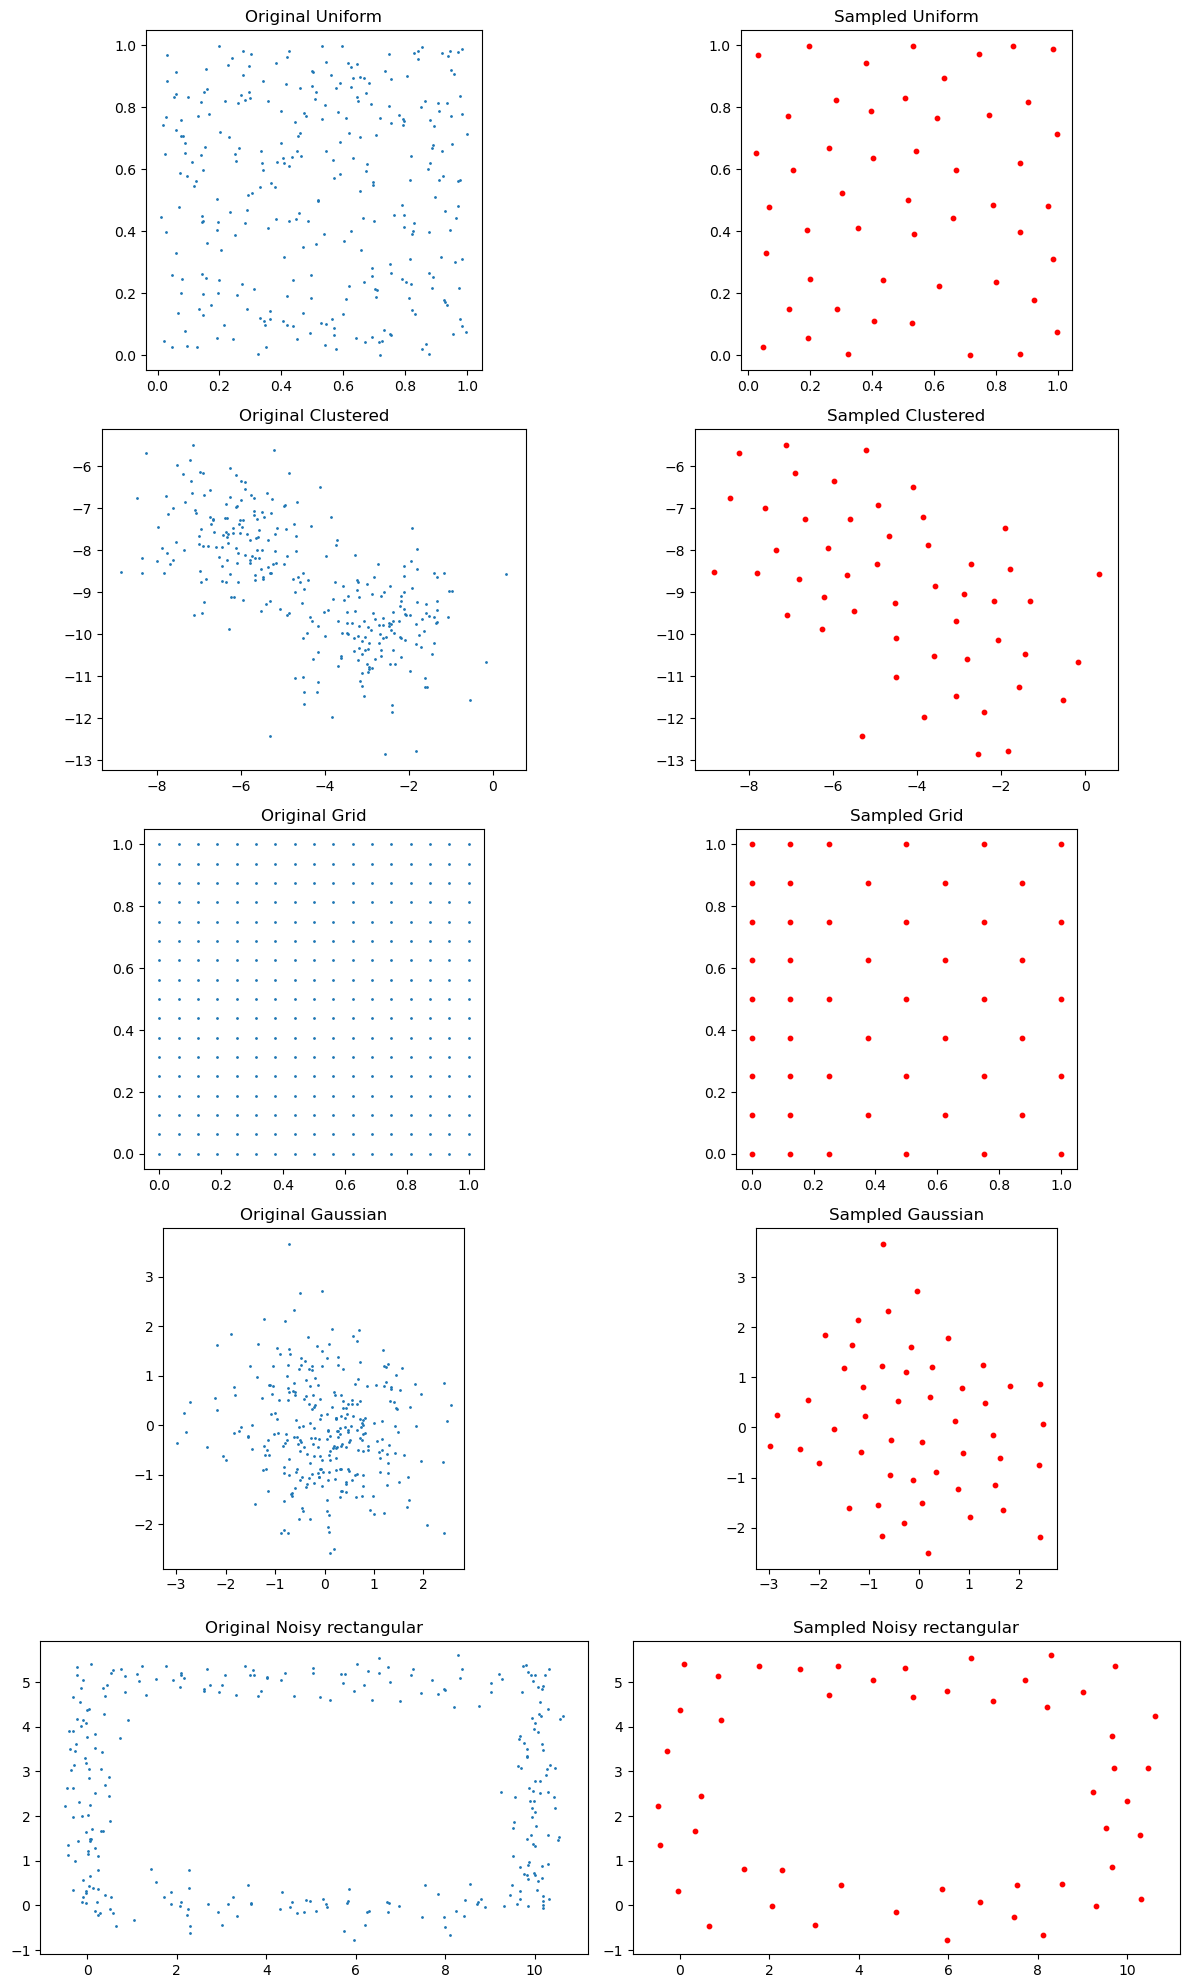

In [44]:

def applyalgo(algorithm, P, k):
    start_time = time.time()
    centers = algorithm(P, 0, k)
    end_time = time.time()
    runtime = end_time - start_time
    return runtime, centers


fig, axs = plt.subplots(5, 2, figsize=(12, 20))

n=300
datasets = {
    "uniform": generate_uniform_points(n),
    "clustered": generate_clustered_points(n),
    "grid": generate_grid_points(n),
    "gaussian": generate_gaussian_points(n),
    "noisy_rectangular": generate_noisy_rectangular_dataset(n, 10, 5, 0.3)
}

k = 50
for idx, (dataset_name, points) in enumerate(datasets.items()):
    runtime, centers = applyalgo(efficient_algorithm, points, k)


    axs[idx, 0].scatter(*zip(*points), s=1)
    axs[idx, 0].set_title(f'Original {dataset_name.replace("_", " ").capitalize()}')
    axs[idx, 0].set_aspect('equal')


    sampled_points = [points[i] for i in centers]
    axs[idx, 1].scatter(*zip(*sampled_points), s=10, color='red')
    axs[idx, 1].set_title(f'Sampled {dataset_name.replace("_", " ").capitalize()}')
    axs[idx, 1].set_aspect('equal')


plt.tight_layout()
plt.show()

* ***Fin***